<a href="https://colab.research.google.com/github/Azeemahma/RNN-Sentiment-Analysis/blob/master/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Time to run
import time
start_time = time.time()

# import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,LSTM , GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import  Embedding
from tensorflow.keras.models import Sequential
import tensorflow as tf
import itertools
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("Tensorflow Version: {}".format(tf.__version__))

Tensorflow Version: 2.18.0


In [ ]:
def clean_review(text):
    '''
    Utility function to clean review text by removing links, special characters
    using simple regex statements.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split()).lower()

def plot_confusion_metrix(y_true, y_pred,classes,
                         normalize=False,
                         title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    """
    Objective
    ----------
    plot confussion matrix, classification report and accuracy score

    parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.

    y_pred : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.

    classes : list
        List of labels to index the matrix

    title : title for matrix
    cmap : colormap for matrix

    returns
    ----------
   all accruacy matrix
    """


    cm = confusion_matrix(y_true,y_pred)


    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix, Without Normalisation")


    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=35)
    plt.yticks(tick_marks,classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() /2.

    for i , j in itertools.product(range(cm.shape[0]), range(cm.shape[0])):
        plt.text(j, i, format(cm[i,j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # plt.tight_layout()

    plt.show()

    print("-----------------------------------------------------")
    print('Classification report')
    print(classification_report(y_true,y_pred))

    print("-----------------------------------------------------")
    acc= accuracy_score(y_true,y_pred)
    print("Accuracy of the model: ", acc)

def calculate_execution_time(start_time, end_time):
    execution_time = end_time - start_time  # Time in seconds
    minutes, seconds = divmod(execution_time, 60)  # Extracting minutes and seconds
    return f"Execution time: {int(minutes)} minutes and {seconds:.2f} seconds"


In [ ]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
df = pd.read_csv("/content/IMDB Dataset.csv")

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.shape

(50000, 2)

In [ ]:
df_train = df.iloc[:40000]
df_test = df.iloc[40000:]

# write to disk
df_train.to_csv("movie_reviews_train.csv", index=False)
df_test.to_csv("movie_reviews_test.csv", index=False)

In [ ]:
print(df_train.shape) # this dataset contain 40000 records and 2 columns for training
print(df_test.shape) # this dataset contain 10000 records and 2 columns for testing

(40000, 2)
(10000, 2)


In [ ]:
df_train.columns

Index(['review', 'sentiment'], dtype='object')

In [ ]:
df_train["review"][5]

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

In [ ]:
df_train['sentiment'].value_counts()

,count
sentiment,
negative,20007
positive,19993


In [ ]:
df_train.isnull().sum()

,0
review,0
sentiment,0


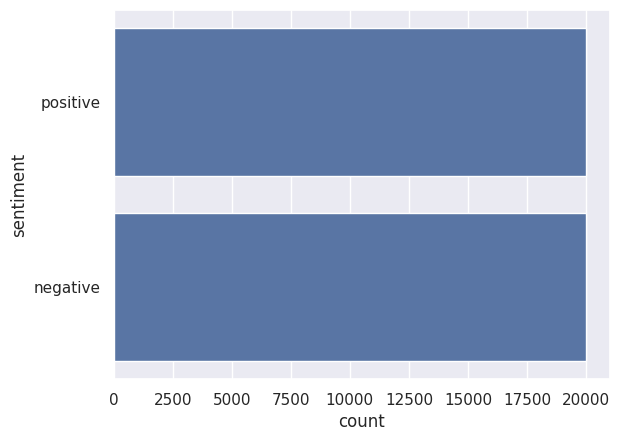

In [ ]:
sns.countplot(df_train["sentiment"])
plt.show()

In [ ]:
Neg = round(df_train["sentiment"].value_counts()[1]/len(df_train) * 100, 2)
Pos = round(df_train["sentiment"].value_counts()[0]/len(df_train) * 100, 2)


print('This train_dataset contain {}% Negative Sentiment tweet'.format(Neg))
print('This train_dataset contain {}% Positive Sentiment tweet'.format(Pos))

This train_dataset contain 49.98% Negative Sentiment tweet
This train_dataset contain 50.02% Positive Sentiment tweet


In [ ]:
# create a label columns using manual label encoding
lab = {"positive":1,"negative":0}
df_train['label']= df_train["sentiment"].map(lab)
df_train.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [ ]:
# clean text
df_train["clean_review"] = df_train["review"].apply(lambda text : clean_review(text))

In [ ]:
df_train.head()

,review,sentiment,label,clean_review
0,One of the other reviewers has mentioned that ...,positive,1,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,1,a wonderful little production br br the filmin...
2,I thought this was a wonderful way to spend ti...,positive,1,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,0,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter mattei s love in the time of money is a...


In [ ]:
df_train.head()

,clean_review,label
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is a...,1


In [ ]:
df_train = df_train[["clean_review", "label"]]

In [ ]:
# check for missing values
df_train.isnull().sum()

# drop missing rows
# df_train = df_train.dropna()
# df_train.isnull().sum()

,0
clean_review,0
label,0


In [ ]:
# convert training dataset into tensorflow dataset format
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(df_train["clean_review"].values, tf.string),
            tf.cast(df_train['label'].values, tf.int32)
        )
    )
)

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [ ]:
# print first five records from train dataset
for example, label in train_dataset.take(5):
    print("--"*50)
    print("example : ", example.numpy())
    print()
    print("label: ", label.numpy())

----------------------------------------------------------------------------------------------------
example :  b'one of the other reviewers has mentioned that after watching just 1 oz episode you ll be hooked they are right as this is exactly what happened with me br br the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word br br it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never f

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64